In [66]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## Curve fitting

This is a first pass at figuring out how to do our (somewhat complicated) curve fitting.  We'll be combining multiple data sets, which might require some tweaking of the curve_fit usage.

We'll start by making up some data.  For our real data, our fitting function is going to be something like

$$v_{rot}^2 = v_{lum}^2 + \alpha v_{LCM}^2$$

where our $v_{LCM}^2$ is a function of the $v_{lum}^2$.  In the real data, the $\alpha$ will be different for each of our galaxies, but we'll be able to get it from a single $\beta$ parameter. We'll also want the LCM calculation to depend on a parameter ($\phi_0$ in the real data), though we won't use that ability for this first pass.  I'll set $\alpha$ to be a function of the galaxy information.

We'll build up to it.  Let's start really simple, with just an x and a y

$$y = C - (x - \alpha)^2$$

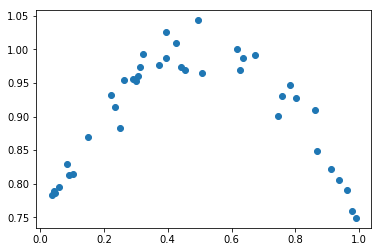

In [145]:
#Setting the seed ensures each run gets the same "random" data
np.random.seed(46)

x = np.random.uniform(0,1,size=[40])
x.sort()
y = 1.0-(x - 0.5)*(x - 0.5) + np.random.normal(0,0.02,size=[40])

plt.plot(x,y,'o')

We need to define a fitting function, the first argument is our input data (in this case, just a single dimensional array of x values), all subsequent arguments are assumed to be fit parameters.  We'll have two, corresponding to our $\alpha$ and $C$, in that order (which is arbitrary, of course).

In [146]:
def simple(xx,alpha,const):
    return const - (xx-alpha)**2

In [147]:
import scipy.optimize
vals, cov = sp.optimize.curve_fit(simple,x,y)
print(vals)
print(cov)
errs = np.sqrt(np.diag(cov))
print("alpha: {:.3} ± {:.2}; C: {:.4} ± {:.2}".format(vals[0], errs[0], vals[1], errs[1]))

[0.50542472 0.99844647]
[[3.06041994e-05 2.23965235e-06]
 [2.23965235e-06 1.11785691e-05]]
alpha: 0.505 ± 0.0055; C: 0.9984 ± 0.0033


Well, that seemed to work, since our input values were $\alpha = 0.5$ and $C = 1.0$.  The output is the fit parameter values, then the covariance matrix.  Strictly speaking we should do more work to get this to be error bars, but I was lazy and just used the square roots of the diagonal entries.

Ok, time to step it up.  Our real problem involves an integral, which seems like it's going to make things more complicated.  Let's try one of those.  This means having two data sets: the one before integration and the one after.

We'll keep the same data set as our last one, and now add a second

$$z = y + \beta \int_{0}^x \sqrt{y(\phi) - \eta}\ d\phi $$

where $\phi$ is a dummy integration variable.  Our new fit parameters are $\beta$ and $\eta$.

Now we need to compute our measured z data.  I'm going to be lazy and do it numerically, choosing $\beta = 1.5$ and $\eta = 0.4$.  Note that we are _assuming_ we know the $\alpha$ and $C$ from before, we're no longer fitting that - strictly speaking, we don't need to know, as that information is bound up in $y$ now.  We could if we wanted.

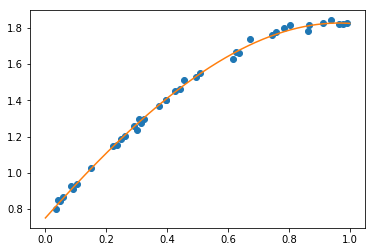

In [149]:
import scipy.integrate
import scipy.interpolate
gen_x = np.linspace(0,1,1001)
gen_y = 1 - (gen_x - 0.5)**2
##Need to check on what cumtrapz does for the zero point
gen_z = sp.integrate.cumtrapz(np.sqrt(gen_y - 0.4), gen_x)
gen_z = np.append(np.array([0]), gen_z)
gen_fz = sp.interpolate.interp1d(gen_x, gen_z)
z = 1.5*gen_fz(x) + np.random.normal(0,0.015,size=[40]) + 1 - (x - 0.5)**2
plt.plot(x,z,'o')
plt.plot(gen_x,1.5*gen_z + gen_y)

So far so good, we have some data now.  Now we need to define our fitting function - it's going to take in an x and a y array and return a z array.

In [234]:
def integrated(xy, beta, eta):
    xx, yy = xy
    zz = sp.integrate.cumtrapz(np.sqrt(yy - eta), xx)
    return beta*np.append(np.array([0]), zz) + yy 

In [235]:
def integrated_fixed(xy, beta):
    xx, yy = xy
    zz = sp.integrate.cumtrapz(np.sqrt(yy - 0.4), xx)
    return beta*np.append(np.array([0]), zz) + yy 

In [236]:
#I increased maxfev from the default of 600, it's the max number of iterations
vals, cov = sp.optimize.curve_fit(integrated_fixed,(x,y),z,maxfev=10000)
print(vals)
print(cov)

[1.57661705]
[[0.00021011]]


Well, that sort of works with a fixed value of $\eta$.  If I try to fit $\eta$ as well, it finds other minima (not the one I want).  We'll have to find a workaround - I suspect some sort of smoothed version of the $y$ values would help, but we'd need to test that.

Ok, last stop.  We need to fit several sets at once, with potentially different ranges.  We're going to have to find a way to either cheat the `curve_fit` utility, or we can switch out to the more general `minimize` utility.

Let's generate some more data sets, but let's make them slightly different - we'll have them be over (slightly) different x ranges, and adjust our $\alpha$ for each one to be the midpoint of the range, so that we need different models for each.

In [237]:
x2 = np.random.uniform(0,1.4,size=[40])
x2.sort()
y2 = 1.0-(x2 - 0.7)**2 + np.random.normal(0,0.015,size=[40])

gen_x = np.linspace(0,1.4,1001)
gen_y = 1 - (gen_x - 0.7)**2
##Need to check on what cumtrapz does for the zero point
gen_z = sp.integrate.cumtrapz(np.sqrt(gen_y - 0.4), gen_x)
gen_z = np.append(np.array([0]), gen_z)
gen_fz = sp.interpolate.interp1d(gen_x, gen_z)
z2 = 1.5*gen_fz(x2) + np.random.normal(0,0.015,size=[40]) + 1 - (x2 - 0.7)**2

In [238]:
x3 = np.random.uniform(0,0.8,size=[40])
x3.sort()
y3 = 1.0-(x3 - 0.4)**2 + np.random.normal(0,0.015,size=[40])

gen_x = np.linspace(0,0.8,1001)
gen_y = 1 - (gen_x - 0.4)**2
##Need to check on what cumtrapz does for the zero point
gen_z = sp.integrate.cumtrapz(np.sqrt(gen_y - 0.4), gen_x)
gen_z = np.append(np.array([0]), gen_z)
gen_fz = sp.interpolate.interp1d(gen_x, gen_z)
z3 = 1.5*gen_fz(x3) + np.random.normal(0,0.015,size=[40]) + 1 - (x3 - 0.4)**2

In [242]:
#Test each individually
print(sp.optimize.curve_fit(integrated_fixed,(x2,y2),z2,maxfev=10000))
print(sp.optimize.curve_fit(integrated_fixed,(x3,y3),z3,maxfev=10000))

(array([1.51364009]), array([[4.3064486e-05]]))
(array([1.5351067]), array([[9.67470783e-05]]))


Now we need to decide what to do.  If we want to cheat the `curve_fit` method, we'll have to add an extra bit of information to tell the data sets apart.  If we want to use `minimize`, we'll have to do least squares on our own.  Both should work, I'm going to try the latter for now.

In [245]:
# Sets will be our data sets, input format [(x1,y1,z1),(x2,y2,z2), ...]
def all_sets(beta, datasets):
    def set_error(x,y,z):
        #There's a decision to make here - do we divide by the length of the set?
        #That means sets with more data points count more
        errs = (z - integrated_fixed((x,y),beta))**2
        return sum(errs)
    
    return sum([set_error(data[0],data[1],data[2]) for data in datasets])

In [246]:
sp.optimize.minimize(all_sets, [1], args=[(x,y,z),(x2,y2,z2),(x3,y3,z3)])

      fun: 0.10565474181737251
 hess_inv: array([[0.0201914]])
      jac: array([1.21071935e-08])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([1.53242218])

Oh, hey, that actually worked.  Great!  That wasn't so terrible.  We aren't taking error bars in to account, unfortunately, but that's something we can do pretty easily by altering our `errs` term.  Let's do this rather than trying to cheat `curve_fit`, I tried and it's pretty involved.